In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import plotly as py
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
from IPython.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate

In [2]:
data = pd.read_csv('C:/Users/b4bsas/Downloads/cannabis.csv')

In [3]:
data["Type"] = pd.factorize(data["Type"])[0]
del data["Description"]

data.head()

,Strain,Type,Rating,Effects,Flavor
0,100-Og,0,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus"
1,98-White-Widow,0,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel"
2,1024,1,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody"
3,13-Dawgs,0,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit"
4,24K-Gold,0,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange"


In [4]:
data_effect = pd.DataFrame(data.Effects.str.split(',',4).tolist(),
             columns = ['Effect_1','Effect_2','Effect_3','Effect_4','Effect_5'])

data_flavors = pd.DataFrame(data.Flavor.str.split(',',n=2,expand=True).values.tolist(),
                          columns = ['Flavor_1','Flavor_2','Flavor_3'])
data = pd.concat([data, data_effect], axis=1)
data = pd.concat([data, data_flavors], axis=1)
del data["Effects"]
del data["Flavor"]
data.head()
dummy = pd.get_dummies(data[['Effect_1','Effect_2','Effect_3','Effect_4','Effect_5','Flavor_1','Flavor_2','Flavor_3']])

,Strain,Type,Rating,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Flavor_1,Flavor_2,Flavor_3
0,100-Og,0,4.0,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus
1,98-White-Widow,0,4.7,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel
2,1024,1,4.4,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody
3,13-Dawgs,0,4.2,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit
4,24K-Gold,0,4.6,Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange


In [5]:
data = pd.concat([data, dummy], axis=1)

data = data.drop(['Strain','Effect_1','Effect_2','Effect_3','Effect_4',
                        'Effect_5','Flavor_1','Flavor_2','Flavor_3'], axis=1)

data.shape
data.head()

(2351, 232)

,Type,Rating,Effect_1_Aroused,Effect_1_Creative,Effect_1_Dry,Effect_1_Energetic,Effect_1_Euphoric,Effect_1_Focused,Effect_1_Giggly,Effect_1_Happy,Effect_1_Hungry,Effect_1_None,Effect_1_Relaxed,Effect_1_Sleepy,Effect_1_Talkative,Effect_1_Tingly,Effect_1_Uplifted,Effect_2_Aroused,Effect_2_Creative,Effect_2_Energetic,Effect_2_Euphoric,Effect_2_Focused,Effect_2_Giggly,Effect_2_Happy,Effect_2_Hungry,Effect_2_Mouth,Effect_2_Relaxed,Effect_2_Sleepy,Effect_2_Talkative,Effect_2_Tingly,Effect_2_Uplifted,Effect_3_Aroused,Effect_3_Creative,Effect_3_Energetic,Effect_3_Euphoric,Effect_3_Focused,Effect_3_Giggly,Effect_3_Happy,Effect_3_Hungry,Effect_3_Relaxed,Effect_3_Sleepy,Effect_3_Talkative,Effect_3_Tingly,Effect_3_Uplifted,Effect_4_Aroused,Effect_4_Creative,Effect_4_Energetic,Effect_4_Euphoric,Effect_4_Focused,Effect_4_Giggly,Effect_4_Happy,Effect_4_Hungry,Effect_4_Relaxed,Effect_4_Sleepy,Effect_4_Talkative,Effect_4_Tingly,Effect_4_Uplifted,Effect_5_Aroused,Effect_5_Creative,Effect_5_Energetic,Effect_5_Euphoric,Effect_5_Focused,Effect_5_Giggly,Effect_5_Happy,Effect_5_Hungry,Effect_5_Relaxed,Effect_5_Sleepy,Effect_5_Talkative,Effect_5_Tingly,Effect_5_Uplifted,Flavor_1_Ammonia,Flavor_1_Apple,Flavor_1_Apricot,Flavor_1_Berry,Flavor_1_Blue,Flavor_1_Blueberry,Flavor_1_Butter,Flavor_1_Cheese,Flavor_1_Chemical,Flavor_1_Citrus,Flavor_1_Coffee,Flavor_1_Diesel,Flavor_1_Earthy,Flavor_1_Flowery,Flavor_1_Grape,Flavor_1_Grapefruit,Flavor_1_Honey,Flavor_1_Lavender,Flavor_1_Lemon,Flavor_1_Lime,Flavor_1_Mango,Flavor_1_Menthol,Flavor_1_Mint,Flavor_1_Minty,Flavor_1_None,Flavor_1_Nutty,Flavor_1_Orange,Flavor_1_Peach,Flavor_1_Pear,Flavor_1_Pepper,Flavor_1_Pine,Flavor_1_Pineapple,Flavor_1_Plum,Flavor_1_Pungent,Flavor_1_Rose,Flavor_1_Sage,Flavor_1_Skunk,Flavor_1_Spicy/Herbal,Flavor_1_Strawberry,Flavor_1_Sweet,Flavor_1_Tar,Flavor_1_Tea,Flavor_1_Tobacco,Flavor_1_Tree,Flavor_1_Tropical,Flavor_1_Vanilla,Flavor_1_Violet,Flavor_1_Woody,Flavor_2_Ammonia,Flavor_2_Apple,Flavor_2_Apricot,Flavor_2_Berry,Flavor_2_Blue,Flavor_2_Blueberry,Flavor_2_Butter,Flavor_2_Cheese,Flavor_2_Chemical,Flavor_2_Chestnut,Flavor_2_Citrus,Flavor_2_Coffee,Flavor_2_Diesel,Flavor_2_Earthy,Flavor_2_Flowery,Flavor_2_Fruit,Flavor_2_Grape,Flavor_2_Grapefruit,Flavor_2_Honey,Flavor_2_Lavender,Flavor_2_Lemon,Flavor_2_Lime,Flavor_2_Mango,Flavor_2_Menthol,Flavor_2_Mint,Flavor_2_Minty,Flavor_2_Nutty,Flavor_2_Orange,Flavor_2_Pear,Flavor_2_Pepper,Flavor_2_Pine,Flavor_2_Pineapple,Flavor_2_Plum,Flavor_2_Pungent,Flavor_2_Rose,Flavor_2_Sage,Flavor_2_Skunk,Flavor_2_Spicy/Herbal,Flavor_2_Strawberry,Flavor_2_Sweet,Flavor_2_Tea,Flavor_2_Tobacco,Flavor_2_Tree,Flavor_2_Tropical,Flavor_2_Vanilla,Flavor_2_Violet,Flavor_2_Woody,Flavor_3_Ammonia,Flavor_3_Apple,Flavor_3_Apricot,Flavor_3_Berry,"Flavor_3_Blue,Cheese",Flavor_3_Blueberry,Flavor_3_Butter,Flavor_3_Cheese,"Flavor_3_Cheese,Blueberry","Flavor_3_Cheese,Chemical","Flavor_3_Cheese,Earthy","Flavor_3_Cheese,Pungent",Flavor_3_Chemical,Flavor_3_Chestnut,Flavor_3_Citrus,"Flavor_3_Citrus,Orange",Flavor_3_Coffee,Flavor_3_Diesel,Flavor_3_Earthy,"Flavor_3_Earthy,Pine","Flavor_3_Earthy,Sweet",Flavor_3_Flowery,"Flavor_3_Fruit,Apricot","Flavor_3_Fruit,Berry","Flavor_3_Fruit,Cheese","Flavor_3_Fruit,Earthy","Flavor_3_Fruit,Flowery","Flavor_3_Fruit,Lemon","Flavor_3_Fruit,Pine","Flavor_3_Fruit,Pineapple","Flavor_3_Fruit,Spicy/Herbal","Flavor_3_Fruit,Sweet",Flavor_3_Grape,Flavor_3_Grapefruit,Flavor_3_Honey,Flavor_3_Lavender,Flavor_3_Lemon,Flavor_3_Lime,Flavor_3_Mango,Flavor_3_Menthol,"Flavor_3_Menthol,Flowery",Flavor_3_Mint,Flavor_3_Minty,Flavor_3_Nutty,Flavor_3_Orange,Flavor_3_Peach,Flavor_3_Pear,Flavor_3_Pepper,Flavor_3_Pine,Flavor_3_Pineapple,Flavor_3_Pungent,"Flavor_3_Pungent,Pine",Flavor_3_Rose,Flavor_3_Sage,Flavor_3_Skunk,Flavor_3_Spicy/Herbal,Flavor_3_Strawberry,Flavor_3_Sweet,"Flavor_3_Sweet,Grape",Flavor_3_Tar,Flavor_3_Tea,Flavor_3_Tobacco,"Flavor_3_Tree,Fruit",Flavor_3_Tropical,Flavor_3_Vanilla,Flavor_3_Violet,Flavor_3_Woody
0,0,4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [6]:
X = data.drop("Type",1)
y = data["Type"]
feature_name = X.columns.tolist()
X = X.astype(np.float64, copy=False)
y = y.astype(np.float64, copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size = 0.2, random_state=42)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)


X_train Shape:  (1880, 231)
X_test Shape:  (471, 231)


In [7]:
def knn(X_train,y_train,X_test, y_test, nei):
    neigh = KNeighborsClassifier(n_neighbors=nei)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    return f1_score(y_test,y_pred, average='micro'), neigh.score(X_test,y_test)

def logreg(X_train,y_train,X_test, y_test, k):
    lr = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial').fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return f1_score(y_test,y_pred, average=k), lr.score(X_test,y_test)

def rndfo(X_train,y_train,X_test, y_test, k):
    clf = RandomForestClassifier(n_estimators=k, max_depth=2,
                            random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test,y_pred, average='micro'),clf.score(X_test,y_test)

def svc(X_train,y_train,X_test, y_test, k):
    svm = SVC(gamma=k)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return f1_score(y_test,y_pred, average='micro'), svm.score(X_test,y_test)

def dtre(X_train,y_train,X_test, y_test, k):
    tr = DecisionTreeClassifier(random_state=0, max_depth=k)
    tr.fit(X_train, y_train)
    y_pred = tr.predict(X_test)
    return f1_score(y_test,y_pred, average='micro'), tr.score(X_test,y_test)

In [8]:
def test(method, X_train ,y_train,X_test, y_test, k, alist):
    dic={}
    d2= {}
    for k in alist:
        s1, s2 = method(X_train,y_train,X_test, y_test,k)
        dic[k]=s1  
        d2[k]=s2
    return dic,d2

def plot(dic):
    colors = list("rgbcmykrgbcmyk")
    o = 0
    m = 0
    n = 0
    for key in dic:
        o = m
        m = max(m,dic[key])
        if o !=  m:
            n = key
        plt.scatter(key, dic[key], label=key,color=colors.pop());
    plt.legend()
    plt.title('best: '+str(n)+" -> "+str(round(m,4)))
    plt.show();

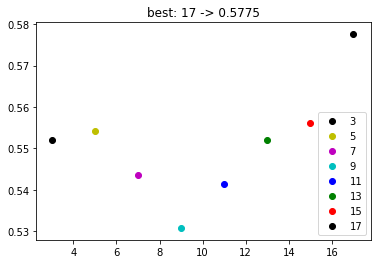

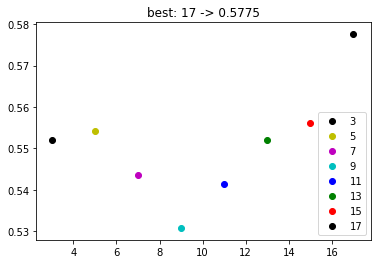

In [9]:
dic, d2 = test(knn, X_train ,y_train,X_test, y_test, 3, [3,5,7,9,11,13,15,17])
plot(dic)
plot(d2)

c:\users\b4bsas\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

c:\users\b4bsas\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

c:\users\b4bsas\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



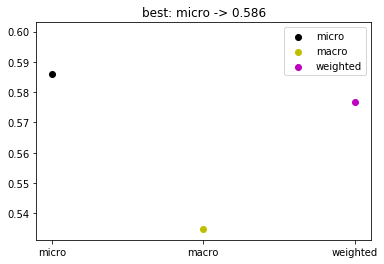

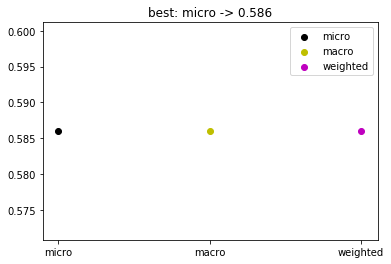

In [10]:
dic, d2 = test(logreg, X_train ,y_train,X_test,
           y_test, 0, ['micro','macro','weighted'])
plot(dic)
plot(d2)

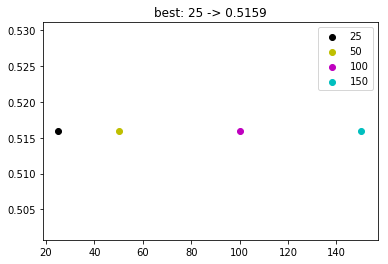

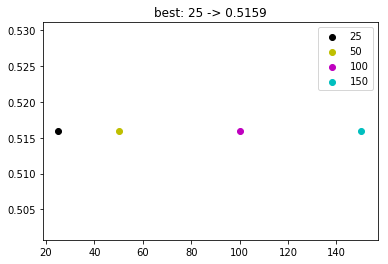

In [11]:
dic, d2 = test(rndfo, X_train ,y_train,X_test,
           y_test, 0, [25, 50,100, 150])
plot(dic)
plot(d2)

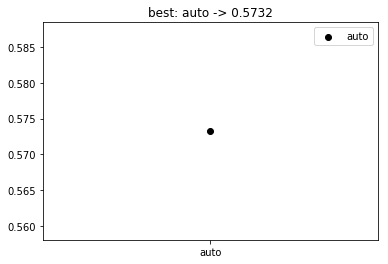

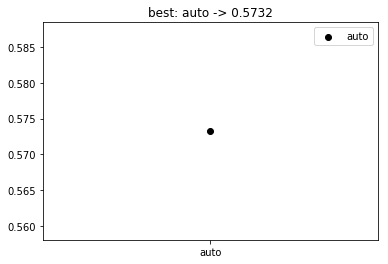

In [12]:
dic, d2 = test(svc, X_train ,y_train,X_test,
           y_test, 0, ['auto'])#,'rbf','poly','sigmoid'])
plot(dic)
plot(d2)

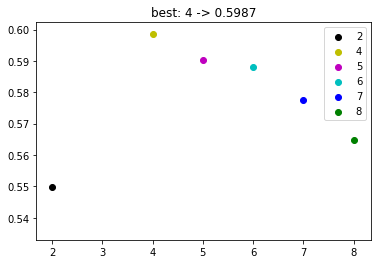

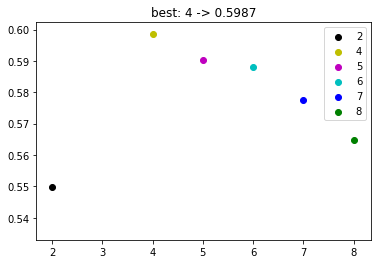

In [13]:
dic, d2 = test(dtre, X_train ,y_train,X_test,
           y_test, 0, [2,4,5,6,7,8])
plot(dic)
plot(d2)